In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

import os
os.chdir("../")

from src.diffusivity import within_ellipsoid
from src.plots import (
    make_quantile_contour_plot, 
    make_basic_diffusivity_plot,
    make_stage_plot)
    
from src.diffusivity import (
    calculate_linear_bayesian_diffusivities, 
    calculate_non_linear_bayesian_diffusivities 
)

In [2]:
# set parameters
params = {
    'plausible_ellipsoid_lwh': [1000, 400, 600],
    'onstrike_angle_deg': 50,
    'min_pts': 5,
    'k_mu': 100,
    'k_sigma': 50,
    'po_mu': 7,
    'po_sigma': 1,
    'do_x_mu': 2,
    'do_x_sigma': 1.5,
    'do_y_mu': 0.5,
    'do_y_sigma': 0.375,
    'do_z_mu': 1,
    'do_z_sigma': 0.75,
    'nuts_target_accept': 0.85,
    'total_draws': 10000,
    'burn_in': 500,
    'n_chains': 4
}

In [3]:
# read the distances
distances = pd.read_csv('data/ms_stage_distances.csv')

In [4]:
# run the plausible ellipsoid filter
distances["in_frac_ellipsoid"] = within_ellipsoid(
    distances[["dx_strike_m", "dy_strike_m", "dz_strike_m"]].to_numpy(),
    ellipsoid_rxryrz=params['plausible_ellipsoid_lwh']
)

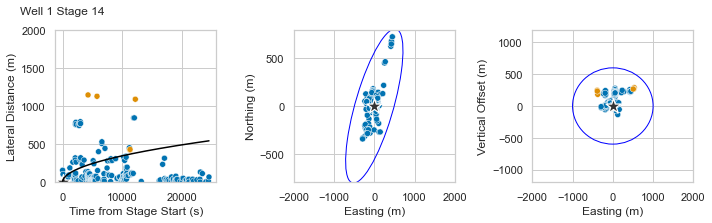

In [5]:
# run our three case studies
# standard stage: well = 1, stage = 14
# sparse data stage: well = 3, stage = 72"
# high induced seismicity: well = 4, stage = 7
well = 1
stage = 14
if well is None or stage is None:
    print('run_all')

make_stage_plot(distances, params, well=well, stage=stage, Do=2)
dist_grp = distances.query('in_frac_ellipsoid').groupby(["WellID","Stage"]).get_group((well,stage))

In [6]:
import cloudpickle
import numpy as np
import pandas as pd
import arviz as az
import aesara.tensor as at 
from aesara.tensor.random.op import RandomVariable
from pymc.aesaraf import floatX
from aesara.raise_op import Assert
from pymc.distributions import Continuous
from pymc.distributions.dist_math import check_parameters
from pymc.distributions.shape_utils import rv_size_is_none
from scipy.optimize import minimize_scalar
from typing import Dict, List, Tuple
import pymc as pm
from src.diffusivity import make_failed_linear_summary, AsymmetricLaplaceQuantile

from src.plots import (
    make_stage_w_posterior_predictive_plot,
    make_linear_trace_analysis_plot,
    make_nonlinear_trace_analysis_plot
    )

from src.diffusivity import (
    calc_tilda_c, 
    linear_diffusivity, 
    within_ellipsoid, 
    calculate_lsq_diffusivities
    )

In [7]:
with pm.Model() as model:
    prior = pm.Gamma('x', mu=params['do_x_mu'], sigma=params['do_x_sigma'])
    triggering_front_x = AsymmetricLaplaceQuantile('TF_x', sigma=1, p=0.95, mu=np.sqrt(6*prior*t), observed=y)

with model:
    step = pm.NUTS(target_accept=params['nuts_target_accept'])
    trace = pm.sample(2000, step=step, return_inferencedata=True, cores=1, chains=params['n_chains'], tune=params['burn_in'])


NameError: name 't' is not defined

In [ ]:
"""Calculate onstrike lateral, vertical, and perpendicular diffusivity
Requires at least n microseismic events for diffusivity calculations

Args:
    dist_grp (pd.DataFrame): Distance group (one stage in a groupby apply)
    params (Dict): Parameters including prior specifications, container, and quantile GAM model

Returns:
    bool: Whether the run was succesfully executed or not
"""
assert dist_grp.shape[0] > params['min_pts']

uwi = dist_grp.WellID.iloc[0]
stage = dist_grp.Stage.iloc[0]
t = dist_grp['t_start_s'].values
pos_t = t>0
t = t[pos_t]
y_x = dist_grp['dx_strike_m'].abs().values
y_x = y_x[pos_t]
y_y = dist_grp['dy_strike_m'].abs().values
y_y = y_y[pos_t]
y_z = dist_grp['dz_strike_m'].abs().values
y_z = y_z[pos_t]

file_prefix = str(dist_grp.WellID.iloc[0]) + "_" +str(dist_grp.Stage.iloc[0])

try:
    with pm.Model() as model:
        do_x_prior = pm.Gamma('Do_x', mu=params['do_x_mu'], sigma=params['do_x_sigma'])
        do_y_prior = pm.Gamma('Do_y', mu=params['do_y_mu'], sigma=params['do_y_sigma'])
        do_z_prior = pm.Gamma('Do_z', mu=params['do_z_mu'], sigma=params['do_z_sigma'])
        triggering_front_x = AsymmetricLaplaceQuantile('TF_x', sigma=1, p=0.95, mu=np.sqrt(6*do_x_prior*t), observed=y_x)
        triggering_front_y = AsymmetricLaplaceQuantile('TF_y', sigma=1, p=0.95, mu=np.sqrt(6*do_y_prior*t), observed=y_y)
        triggering_front_z = AsymmetricLaplaceQuantile('TF_z', sigma=1, p=0.95, mu=np.sqrt(6*do_z_prior*t), observed=y_z)
    
    with model:
        step = pm.NUTS(target_accept=params['nuts_target_accept'])
        trace = pm.sample(int(params['total_draws']/params['n_chains']), step=step, return_inferencedata=True, cores=1, chains=params['n_chains'], tune=params['burn_in'])

    summary = (az.summary(trace)
        .assign(uwi=uwi)
        .assign(stage=stage)
        .assign(n=dist_grp.shape[0])
        .assign(model='linear')
        .assign(converged=True)
        )
except Exception as e:
    print(e)
    summary = make_failed_linear_summary(dist_grp)
    summary.to_parquet("outputs/" + file_prefix+"_linear.parquet")

summary = (az.summary(trace)
    .assign(uwi=uwi)
    .assign(stage=stage)
    .assign(n=dist_grp.shape[0])
    .assign(model='linear')
    .assign(converged=True)
    )

summary.to_parquet("outputs/" + file_prefix+"_linear.parquet")

Sequential sampling (4 chains in 1 job)
NUTS: [Do_x, Do_y, Do_z]


Sampling 4 chains for 500 tune and 2_500 draw iterations (2_000 + 10_000 draws total) took 61 seconds.


c:\repos\bayesian_diffusivity_inference\src\diffusivity.py:161: RuntimeWarning: invalid value encountered in log
  positive_x = mu - sigma/p * np.log((1-u)/(1-p))


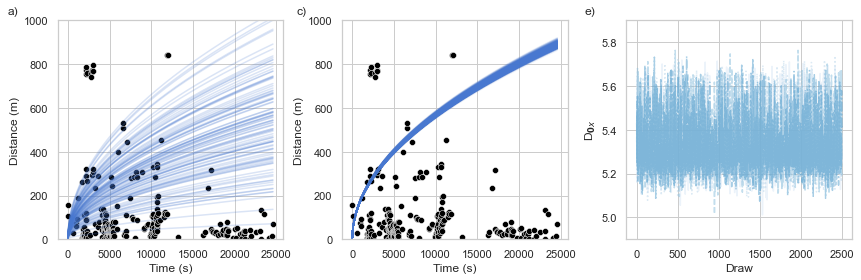

In [ ]:
fig = make_linear_trace_analysis_plot(dist_grp, model, trace, samples=100)
plt.show()

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('tab10')

array([[<AxesSubplot:title={'center':'Do_x'}>,
        <AxesSubplot:title={'center':'Do_x'}>],
       [<AxesSubplot:title={'center':'Do_y'}>,
        <AxesSubplot:title={'center':'Do_y'}>],
       [<AxesSubplot:title={'center':'Do_z'}>,
        <AxesSubplot:title={'center':'Do_z'}>]], dtype=object)

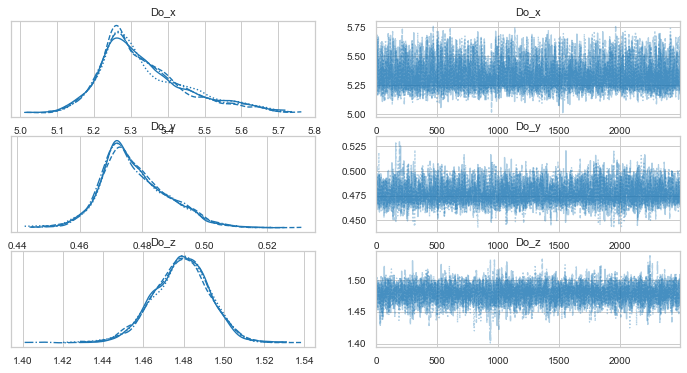

In [ ]:
az.plot_trace(trace)

<AxesSubplot:>

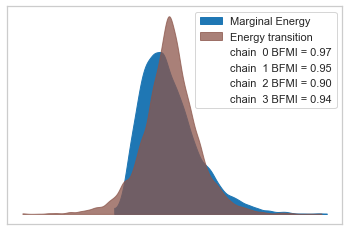

In [ ]:
az.plot_energy(trace)

In [ ]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Do_x,5.334,0.117,5.145,5.583,0.002,0.001,5108.0,5163.0,1.0
Do_y,0.477,0.011,0.460,0.499,0.000,0.000,4554.0,4717.0,1.0
Do_z,1.479,0.014,1.453,1.505,0.000,0.000,4440.0,3932.0,1.0


array([<AxesSubplot:title={'center':'Do_x'}>,
       <AxesSubplot:title={'center':'Do_y'}>,
       <AxesSubplot:title={'center':'Do_z'}>], dtype=object)

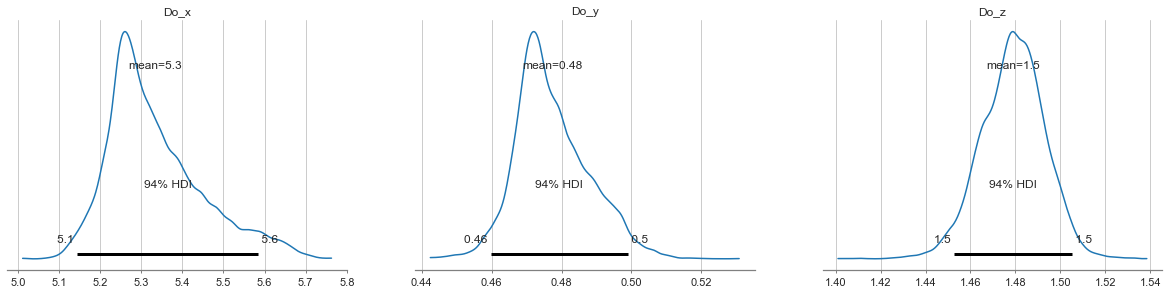

In [ ]:
az.plot_posterior(trace)